# Hands-on Lithium Ion Battery (LIB) modelling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/Energy_storage/blob/main/2-Hands-on_LIB_modelling.ipynb)

In this notebook, we will use the Python library [`PyBaMM`](https://www.pybamm.org/) (Python Battery Mathematical Modelling),
 which includes various models based on the [Differential-Algebraic system of Equations (DAEs)](https://en.wikipedia.org/wiki/Differential-algebraic_system_of_equations), 
 including the P2D model seen in this lesson.

The tutorial is divided into two main parts. 
In the first one, we will take data from the literature on a battery and use them to calculate various properties of it. 
In the second one, we will present a real problem (very simplified) for the choice of the battery using the data calculated before.

## Installing the packages needed

The first thing to do is install all the packages that we will use for this tutorial.

In [1]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pandas
%pip install pybamm==24.1


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Of course, we need to import them before we use them.

In [2]:
from typing import Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybamm
from scipy.integrate import trapz
from scipy.interpolate import interp1d

plt.style.use("seaborn-v0_8-notebook")

## Model definition

We will use the the P2D model by [Doyle-Fuller-Newman](https://www.doi.org/10.1149/1.2221597) (DFN), which generalizes the [Newman-Tiedemann](https://doi.org/10.1002/aic.690210103) model. The procedure of derivation of the equations is similar to that seen in class (mass, charge, and energy balance). The main difference is that in the mass balance, instead of dilute solution theory, we use concentrated solution theory. This is because the energy density of the latest LIBs made Newman's first model (1975) too simplified.


In [3]:
# set the model type
model = pybamm.lithium_ion.DFN()

We are going to model the commercial battery [LG-M50 (5000 mAh)](https://www.batteryspace.com/prod-specs/11514.pdf) using the chemistry and the parameters used in [Chang-Hui Chen *et al.* (2020)](https://iopscience.iop.org/article/10.1149/1945-7111/ab9050) work.

<img src="https://github.com/paolodeangelis/Energy_storage/raw/main/img/LG-M50-5000mAh.jpg" width="400"/>

In [4]:
# Get chemistry form Chen (2020) work
chemistry = pybamm.parameter_sets.Chen2020
chemistry

'Chen2020'

From the chemistry, the library extracts the parameters needed.

In [5]:
param = pybamm.ParameterValues(chemistry)

# Geometrical parameters
param["Negative current collector thickness [m]"] = 1.2e-05
param["Negative electrode thickness [m]"] = 8.52e-05
param["Separator thickness [m]"] = 1.2e-05
param["Positive electrode thickness [m]"] = 7.56e-05
param["Positive current collector thickness [m]"] = 1.6e-05
param["Electrode height [m]"] = 0.065
param["Electrode width [m]"] = 1.58
param["Cell cooling surface area [m2]"] = 0.00531
param["Cell volume [m3]"] = 2.42e-05

To play with the model, we set the Current (`"Current function [A]"`) and the Ambient Temperature (`"Ambient temperature [K]"`)  as **input** of the model. 
Which means that these two parameters now have to be set by the user.

In [6]:
param["Current function [A]"] = "[input]"
param["Ambient temperature [K]"] = "[input]"

We can print all the 98 (!) parameters:

In [7]:
format_str = "{:<75}  {:>20}"
print(format_str.format("PARAMETER", "VALUE"))
print("-" * 97)
for key, value in param.items():
    try:
        print(format_str.format(key, value))
    except TypeError:
        print(format_str.format(key, value.__str__()))

PARAMETER                                                                                   VALUE
-------------------------------------------------------------------------------------------------
Ideal gas constant [J.K-1.mol-1]                                                      8.314462618
Faraday constant [C.mol-1]                                                            96485.33212
Boltzmann constant [J.K-1]                                                           1.380649e-23
Electron charge [C]                                                               1.602176634e-19
Ratio of lithium moles to SEI moles                                                           2.0
Inner SEI reaction proportion                                                                 0.5
Inner SEI partial molar volume [m3.mol-1]                                               9.585e-05
Outer SEI partial molar volume [m3.mol-1]                                               9.585e-05
SEI reaction exchang

## Geometry and Domain discretization

Now we define the geometry and set the discretization of the 1D cylindrical domain.

In [8]:
# set the parameters for the model and the geometry
param.process_model(model)
geometry = pybamm.battery_geometry()
param.process_geometry(geometry)

discretization (i.e mesh size)

In [9]:
# domain discretisation
submesh_types = {
    "negative electrode": pybamm.Uniform1DSubMesh,
    "separator": pybamm.Uniform1DSubMesh,
    "positive electrode": pybamm.Uniform1DSubMesh,
    "negative particle": pybamm.Uniform1DSubMesh,
    "positive particle": pybamm.Uniform1DSubMesh,
    "negative particle size": pybamm.Uniform1DSubMesh,
    "positive particle size": pybamm.Uniform1DSubMesh,
    "current collector": pybamm.SubMesh0D,
}

var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 25, var.x_s: 8, var.x_p: 25, var.r_n: 30, var.r_p: 30}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

We set the [Finite Volume Methos](https://en.wikipedia.org/wiki/Finite_volume_method) as numerical method to solve the [Partial Differential Equations (PDE)](https://en.wikipedia.org/wiki/Partial_differential_equation).

In [10]:
# Spazial integrazion methods
spatial_methods = {
    "current collector": pybamm.ZeroDimensionalSpatialMethod(),
    "macroscale": pybamm.FiniteVolume(),
    "negative particle": pybamm.FiniteVolume(),
    "positive particle": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

Ploting the discretization result.

In [11]:
macroscale = ["negative electrode", "separator", "positive electrode"]
x_var = pybamm.SpatialVariable("x", domain=macroscale)
r_var = pybamm.SpatialVariable("r", domain=["negative particle"])
# Discretise
x_disc = disc.process_symbol(x_var)
r_disc = disc.process_symbol(r_var)

# Evaluate
x = x_disc.evaluate()
r = r_disc.evaluate()
t_ne = param["Negative electrode thickness [m]"]
t_sp = param["Separator thickness [m]"]
t_pe = param["Positive electrode thickness [m]"]
t_cell = t_ne + t_sp + t_pe
r_ne = param["Negative particle radius [m]"]

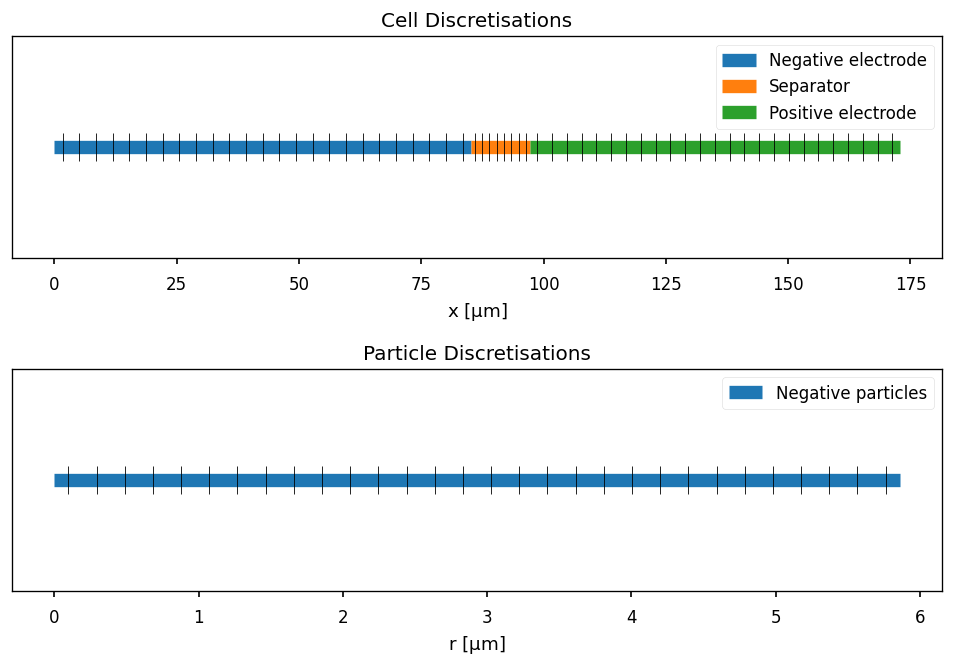

In [12]:
fig = plt.figure(figsize=(10, 6), dpi=120)
m2um = 1e6

with plt.style.context("seaborn-v0_8-notebook"):
    ax_x = fig.add_subplot(211)
    ax_r = fig.add_subplot(212)
    plt.subplots_adjust(hspace=0.5)
    start = 0.0
    for t, label in zip(
        [t_ne, t_sp, t_pe], ["Negative electrode", "Separator", "Positive electrode"]
    ):
        ax_x.plot(
            np.r_[start, start + t] * m2um,
            [0, 0],
            label=label,
            lw=8,
            solid_capstyle="butt",
        )
        start += t
    ax_x.scatter(
        x * m2um,
        np.zeros(len(x)),
        marker="|",
        color="k",
        lw=0.5,
        s=300,
        zorder=10,
    )
    ax_r.plot(
        np.r_[0, r_ne] * m2um,
        [0, 0],
        label="Negative particles",
        lw=8,
        solid_capstyle="butt",
    )
    ax_r.scatter(
        r * m2um,
        np.zeros(len(r)),
        marker="|",
        color="k",
        lw=0.5,
        s=300,
        zorder=10,
    )
    ax_x.set_xlabel(r"x [$\mathrm{\mu m}$]")
    ax_x.set_ylabel(r"y [$\mathrm{\mu m}$]")
    ax_x.get_yaxis().set_visible(False)
    ax_x.legend()
    ax_x.set_title("Cell Discretisations")
    ax_r.set_xlabel(r"r [$\mathrm{\mu m}$]")
    ax_r.get_yaxis().set_visible(False)
    ax_r.legend()
    ax_r.set_title("Particle Discretisations")

plt.show()

## [Study 1] Voltage discharge profile

Now we can compute the discharge curge

In [13]:
NOMINAL_Q = param["Nominal cell capacity [A.h]"]
C_RATE = NOMINAL_Q / 1.0  # [A]
T = 300  # K

Now lets discharge the battery per 1h



In [14]:
# Lets use the default solver to compute the discharge curve
solver = pybamm.CasadiSolver()
n = 3601  # how many point to evaluate
t_eval = np.linspace(0, 3600, n)  # [s] simulation time
solution = solver.solve(
    model, t_eval, inputs={"Current function [A]": C_RATE, "Ambient temperature [K]": T}
)

Plotting the result.

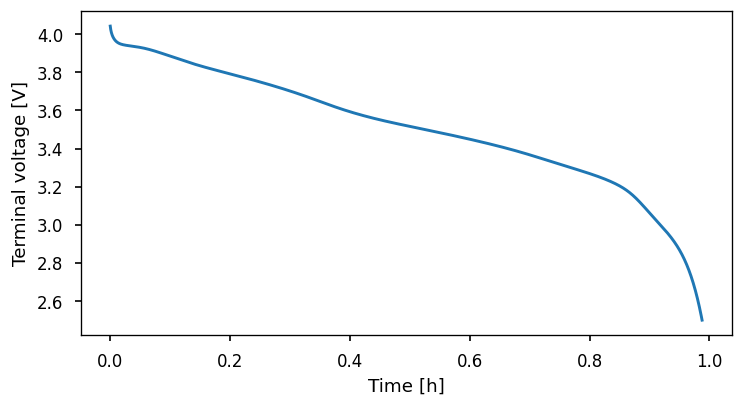

In [15]:
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries
fig = plt.figure(figsize=(7, 3.5), dpi=120)

with plt.style.context("seaborn-v0_8-notebook"):
    ax = fig.add_subplot(111)
    ax.plot(time, voltage)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")

plt.show()

## [Study 2] Effect of C-rate current on the discharge curve 

Here we will perform a parametric study computing the voltage profile at different C Rates.

In [16]:
C_RATES = [2, 1, 0.5]

crate_result = pd.DataFrame(columns=["C-rare", "Time [h]", "Voltage [V]"])

for i, c_rate in enumerate(C_RATES):
    t_eval = np.linspace(0, 3600 / c_rate, int(10000 * c_rate))
    solution = solver.solve(
        model,
        t_eval,
        inputs={"Current function [A]": C_RATE * c_rate, "Ambient temperature [K]": T},
    )
    crate_result.loc[i, "C-rare"] = c_rate
    crate_result.loc[i, "Time [h]"] = solution["Time [h]"].entries
    crate_result.loc[i, "Voltage [V]"] = solution["Terminal voltage [V]"].entries

    print(
        "C ={:>4}: Discharged in {:>6.3g} h".format(
            c_rate, crate_result.loc[i, "Time [h]"].max()
        )
    )

C =   2: Discharged in  0.473 h
C =   1: Discharged in  0.988 h
C = 0.5: Discharged in      2 h


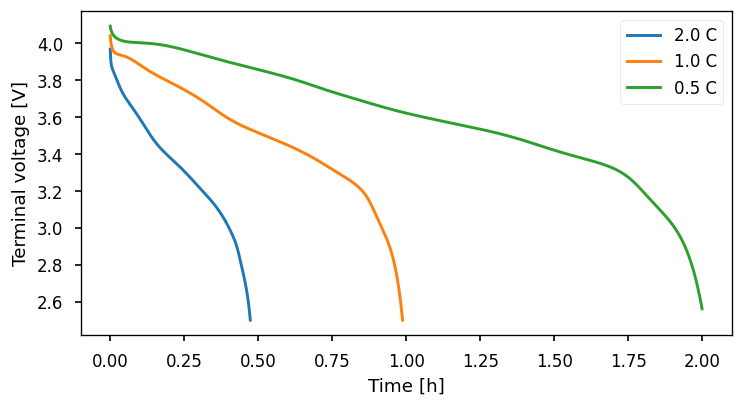

In [17]:
fig = plt.figure(figsize=(7, 3.5), dpi=120)

with plt.style.context("seaborn-v0_8-notebook"):
    ax = fig.add_subplot(111)
    for i, c_rate in enumerate(C_RATES):
        ax.plot(
            crate_result.loc[i, "Time [h]"],
            crate_result.loc[i, "Voltage [V]"],
            label=f"{c_rate:1.1f} C",
        )
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

## [Study 3] Effect of the Temperature (T) on the discharge curve 

Here we will perform a parametric study computing the voltage profile at different Temperature.

In [18]:
T_test = [-30, 0, 30, 60]  # [C°]

temeperature_result = pd.DataFrame(columns=["T [C°]", "Time [h]", "Voltage [V]"])

for i, temp in enumerate(T_test):
    t_eval = np.linspace(0, 3600, 10000)
    solution = solver.solve(
        model,
        t_eval,
        inputs={
            "Current function [A]": C_RATE,
            "Ambient temperature [K]": 273.15 + temp,
        },
    )
    temeperature_result.loc[i, "T [C°]"] = temp
    temeperature_result.loc[i, "Time [h]"] = solution["Time [h]"].entries
    temeperature_result.loc[i, "Voltage [V]"] = solution["Terminal voltage [V]"].entries

    print(
        "T ={:>4} C°: Discharged in {:>6.3g} h".format(
            temp, temeperature_result.loc[i, "Time [h]"].max()
        )
    )

T = -30 C°: Discharged in  0.977 h
T =   0 C°: Discharged in  0.983 h
T =  30 C°: Discharged in  0.988 h
T =  60 C°: Discharged in  0.992 h


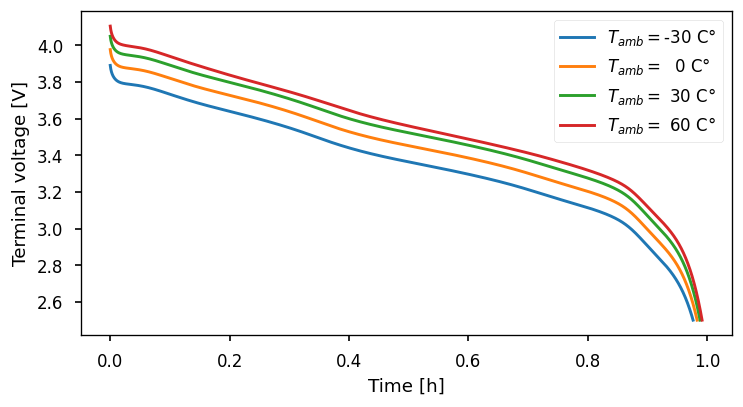

In [19]:
fig = plt.figure(figsize=(7, 3.5), dpi=120)

with plt.style.context("seaborn-v0_8-notebook"):
    ax = fig.add_subplot(111)
    for i, temp in enumerate(T_test):
        ax.plot(
            temeperature_result.loc[i, "Time [h]"],
            temeperature_result.loc[i, "Voltage [V]"],
            label=f"$T_{{amb}}=${temp:>3.0f} C°",
        )
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

## [Study 4] Discharge-Charge voltage profile

We will perform an experiment where we discharge and charge the battery with C/2 constant current two times.

<div class="alert alert-block alert-info">
<b>NOTE: </b> 

During the charge, the battery management system usually charges with C/3 current until 4.1 V; then, it maintains a constant voltage and continue to charge until the current goes below C/20 to ensure a full recharge. 
</div>

In [20]:
model_exp = pybamm.lithium_ion.DFN()
cut_off_l = param["Lower voltage cut-off [V]"]
cut_off_u = param["Upper voltage cut-off [V]"]
experiment = pybamm.Experiment(
    [
        (
            f"Discharge at C/2 for 2 hours or until {cut_off_l} V",
            f"Charge at C/2 for 2.1 hours or until {cut_off_u} V",
            f"Discharge at C/2 for 2 hours or until {cut_off_l} V",
            f"Charge at C/2 for 2.1 hours or until {cut_off_u} V",
        ),
    ]
)
sim = pybamm.Simulation(
    model_exp, experiment=experiment, parameter_values=pybamm.ParameterValues(chemistry)
)
solution = sim.solve()

At t = 505.313 and h = 5.9296e-14, the corrector convergence failed repeatedly or with |h| = hmin.


We define a function to compute the energy, i.e. the area under the discharge curve.

In [21]:
def get_energy(v: np.ndarray, i: Union[np.ndarray, float], t: np.ndarray) -> float:
    """Compute the energy as the integral of the discharge curve.

    Args:
        v (np.ndarray): [V] Voltage array.
        i (np.ndarray | float): [A] Current (constant or array).
        t (np.ndarray): [s] Time arra.

    Returns:
        float: Energy in J.
    """
    return trapz(v * i, x=t)

In [22]:
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries
i_change_0 = np.where(voltage == voltage[(time > 3.5) & (time <= 6.8)].max())[0][0]
i_change_1 = np.where(voltage == voltage[(time > 3.5) & (time <= 6.8)].min())[0][-1]
t_change_0 = time[i_change_0]
t_change_1 = time[i_change_1]
time_discharge = time[(time > t_change_0) & (time <= t_change_1)]
voltage_discharge = voltage[(time > t_change_0) & (time <= t_change_1)]
time_charge = time[time >= t_change_1]
voltage_charge = voltage[time >= t_change_1]

We plot the experiment and compare the second cycle's charge and discharge voltage profile (because it is far from the initial condition).

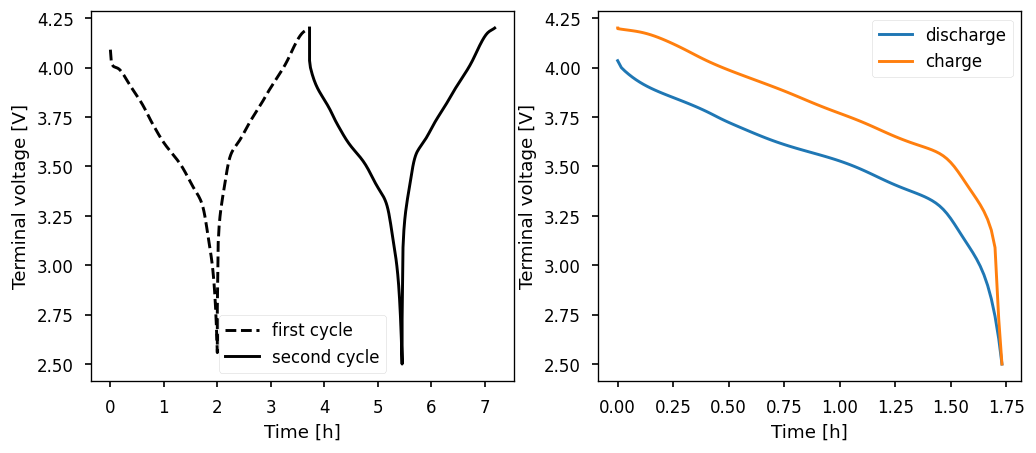

In [23]:
fig = plt.figure(figsize=(10, 4), dpi=120)

with plt.style.context("seaborn-v0_8-notebook"):
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(
        time[time <= t_change_0],
        voltage[time <= t_change_0],
        "--k",
        label="first cycle",
    )
    ax1.plot(
        time[time >= t_change_0],
        voltage[time >= t_change_0],
        "-k",
        label="second cycle",
    )
    ax2.plot(time_discharge - t_change_0, voltage_discharge, label="discharge")
    ax2.plot(time_charge[::-1] - t_change_1, voltage_charge, label="charge")
    for ax in [ax1, ax2]:
        ax.set_xlabel("Time [h]")
        ax.set_ylabel("Terminal voltage [V]")
        ax.legend()
plt.show()

We can also see in detail what happens with an animation.

In [24]:
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=7.187488019893514, step=0.07187488019893513)…

We can also compute LIB storage efficiency by computing the energy used to charge it and the energy supply during the discharge.

In [25]:
energy_discharge = get_energy(
    voltage_discharge, C_RATE / 2, time_discharge
)  # Discharge Energy [J]
energy_charge = get_energy(voltage_charge, C_RATE / 2, time_charge)  # Charge Energy [J]

eta = energy_discharge / energy_charge

print(f"Battery efficiency: {eta*100:1.2f} %")

Battery efficiency: 92.84 %


## [Study 5] Compute the Ragone plot

The lessons show that the Ragone plot is a crucial LIB characteristic. 
We have to perform a discharge experiment at different C-rates to obtain it. 
This may require days (0.01 C = ~100 h for fully discharging the battery) in a lab experiment.

In [26]:
C_RATES = [3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]

crate_result2 = pd.DataFrame(columns=["C-rare", "Time [h]", "Voltage [V]"])

for i, c_rate in enumerate(C_RATES):
    t_eval = np.linspace(0, 4000 / c_rate, max(500, int(20000 * c_rate)))
    solution = solver.solve(
        model,
        t_eval,
        inputs={"Current function [A]": C_RATE * c_rate, "Ambient temperature [K]": T},
    )
    crate_result2.loc[i, "C-rare"] = c_rate
    crate_result2.loc[i, "Time [h]"] = solution["Time [h]"].entries
    crate_result2.loc[i, "Voltage [V]"] = solution["Terminal voltage [V]"].entries

    print(
        "C ={:>4}: Discharged in {:>6.3g} h".format(
            c_rate, crate_result2.loc[i, "Time [h]"].max()
        )
    )

At t = 560.954 and h = 2.58839e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 260.914 and h = 1.03732e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 260.938 and h = 1.81285e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.675 and h = 3.4521e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 35.9742 and h = 7.60076e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 36.0129 and h = 2.82333e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 17.2265 and h = 3.93305e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.86786 and h = 5.15103e-10, the corrector convergence failed repeatedly or with |h| = hmin.


C =   3: Discharged in  0.154 h


At t = 446.253 and h = 6.62116e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.285 and h = 3.62673e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.341 and h = 1.03934e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 71.272 and h = 6.72571e-09, the corrector convergence failed repeatedly or with |h| = hmin.


C = 2.5: Discharged in   0.29 h
C =   2: Discharged in  0.473 h
C = 1.5: Discharged in  0.647 h
C =   1: Discharged in  0.988 h
C =0.75: Discharged in   1.33 h


At t = 303.888 and h = 2.19335e-18, the corrector convergence failed repeatedly or with |h| = hmin.


C = 0.5: Discharged in   2.01 h
C =0.25: Discharged in   4.04 h
C = 0.1: Discharged in   10.2 h
C =0.05: Discharged in   20.4 h
C =0.01: Discharged in    102 h


In [27]:
def get_cell_volume_and_mass(param: dict) -> Tuple[float, float]:
    """Compute the cell volume and mass from the model prameters.

    Args:
        param (dict): Model prameters.

    Returns:
        tuple: containing:
            -  float: [m^3] cell volume.
            -  float: [kg] cell mass.
    """
    vol = param["Cell volume [m3]"]
    t = 0
    rho = 0
    componets = [
        "Negative electrode",
        "Negative current collector",
        "Positive electrode",
        "Positive current collector",
        "Separator",
    ]
    for comp in componets:
        rho_ = param[comp + " density [kg.m-3]"]
        t_ = param[comp + " thickness [m]"]
        rho += rho_ * t_
        t += t_
    rho /= t
    mass = rho * vol
    return vol, mass

We compute the energy and the power for each simulation at diffente C-rate.

In [28]:
CELL_VOL, CELL_MASS = get_cell_volume_and_mass(param)

ragone_result = pd.DataFrame(
    columns=["C-rare", "Specific Power [W/kg]", "Specific Energy [Wh/kg]"]
)

for i, (c_rate, t, v) in enumerate(
    zip(C_RATES, crate_result2["Time [h]"], crate_result2["Voltage [V]"])
):
    energy = get_energy(v, c_rate * C_RATE, t * 3600)  # [J]
    power = energy / (t.max() * 3600)  # [W]
    energy = energy / 3600  # [Wh]
    ragone_result.loc[i, "C-rare"] = c_rate
    ragone_result.loc[i, "Specific Energy [Wh/kg]"] = energy / CELL_MASS
    ragone_result.loc[i, "Specific Power [W/kg]"] = power / CELL_MASS

In [29]:
ragone_result

,C-rare,Specific Power [W/kg],Specific Energy [Wh/kg]
0,3,745.799374,115.19643
1,2.5,629.142472,182.651438
2,2,506.530509,239.743801
3,1.5,390.986202,253.015425
4,1,267.702727,264.451936
5,0.75,203.466654,270.107065
6,0.5,137.529118,275.954642
7,0.25,69.798736,282.287726
8,0.1,28.193176,286.494206
9,0.05,14.144519,287.985419


We define a new function that interpolates the specific power computed before. It will be useful later.

In [30]:
# interpolation function will be useful later
f_Crate_SpecificPower = interp1d(
    ragone_result["C-rare"], ragone_result["Specific Power [W/kg]"]
)

plotting the **Ragone Plot**

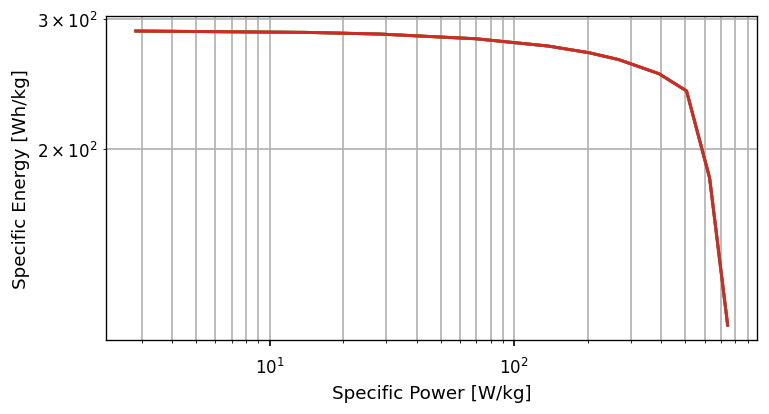

In [31]:
fig = plt.figure(figsize=(7, 3.5), dpi=120)

with plt.style.context("seaborn-v0_8-notebook"):
    ax = fig.add_subplot(111)
    for i, temp in enumerate(T_test):
        ax.loglog(
            ragone_result["Specific Power [W/kg]"],
            ragone_result["Specific Energy [Wh/kg]"],
        )
    ax.set_xlabel("Specific Power [W/kg]")
    ax.set_ylabel("Specific Energy [Wh/kg]")
    ax.grid(True, which="both", ls="-")

plt.show()

## [Study 6] Driving Cycles

Another important application of the model is to test virtually (*in silico*) the battery performance during the operating condition in an Electric car.
There are many standardized diving cycles. We are going to download the [Urban Dynamometer Driving Schedule (UDDS)](https://www.epa.gov/vehicle-and-fuel-emissions-testing/dynamometer-drive-schedules).

![UDDS](https://www.epa.gov/sites/default/files/2015-10/uddsdds.gif)



In [32]:
! wget https://raw.githubusercontent.com/pybamm-team/PyBaMM/838422665fb4d8424abcb441f6123ab354cc1a63/pybamm/input/drive_cycles/UDDS.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
# Import drive cycle from file
drive_cycle = pd.read_csv("UDDS.csv", comment="#", header=None).to_numpy()

# Create interpolant

current_interpolant = pybamm.Interpolant(drive_cycle[:, 0], drive_cycle[:, 1], pybamm.t)

# Set drive cycle
param["Current function [A]"] = current_interpolant
param["Ambient temperature [K]"] = T

Run experiment

In [34]:
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, parameter_values=param)
solution = sim.solve()

Plotting

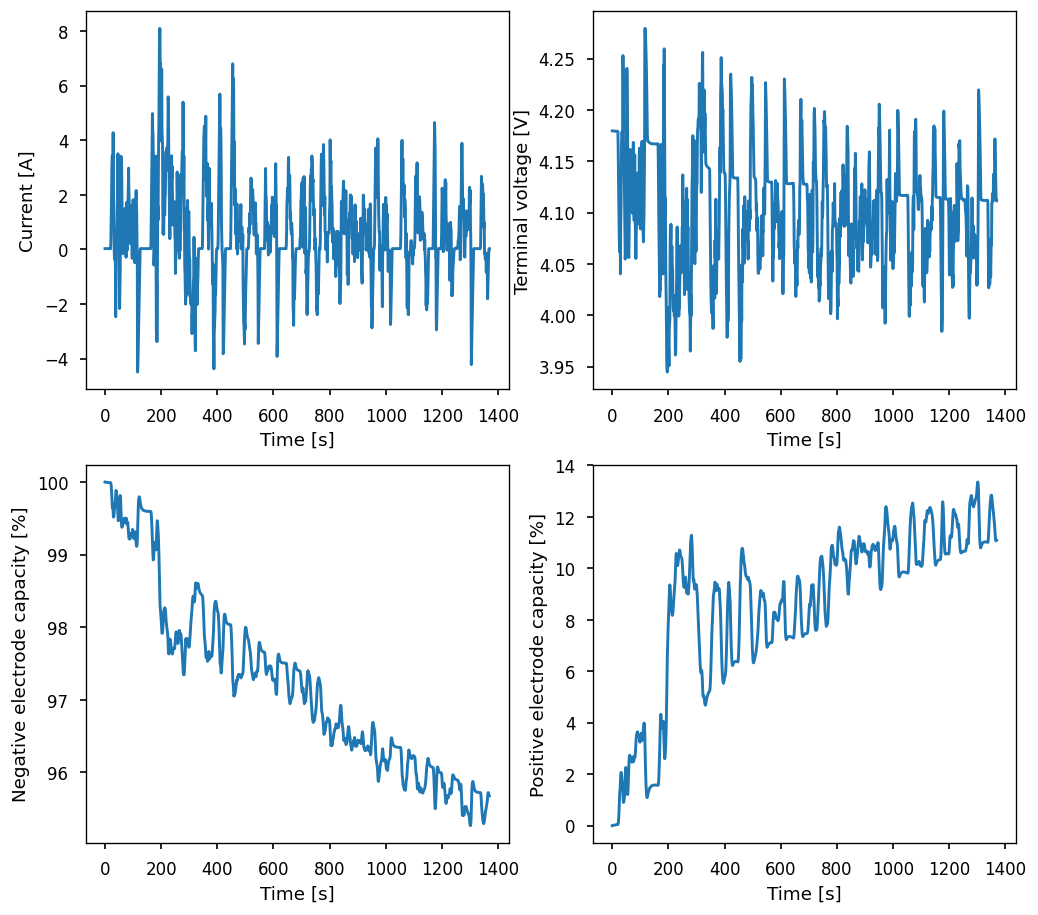

In [35]:
fig = plt.figure(figsize=(10, 9), dpi=120)

with plt.style.context("seaborn-v0_8-notebook"):
    ax = []
    grid = fig.add_gridspec(2, 2)
    for i in range(4):
        ax.append(fig.add_subplot(grid[i]))
    t = solution["Time [s]"].entries
    for i, key in enumerate(["Current [A]", "Terminal voltage [V]"]):
        ax[i].plot(t, solution[key].entries)
        ax[i].set_ylabel(key)
    n_capacity = solution[
        "Negative particle surface concentration [mol.m-3]"
    ].entries.mean(axis=0)
    n_capacity = n_capacity / n_capacity.max() * 100
    ax[2].plot(t, n_capacity)
    ax[2].set_ylabel("Negative electrode capacity [%]")
    p_capacity = solution[
        "Positive particle surface concentration [mol.m-3]"
    ].entries.mean(axis=0)
    p_capacity = (p_capacity - p_capacity.min()) / p_capacity.min() * 100
    ax[3].plot(t, p_capacity)
    ax[3].set_ylabel("Positive electrode capacity [%]")
    for i in range(4):
        ax[i].set_xlabel("Time [s]")

plt.show()

Let's plot others spazial quantities

In [36]:
solution.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1369.0, step=13.69), Output()), _dom_classes…

## Modelling SEI growth

In this part of the notebook, we are going to implement in `pyBAMM` the Solid Electrolyte Interface (SEI) model that we saw in class.

The governing equation of the moving-boundary electrolyte diffusion-limited model are:
for the concentration of electrolyte in the SEI:
$$
\frac{\partial c}{\partial t} = \frac{\hat{V} R}{L} \xi \frac{\partial c}{\partial \xi} + \frac{1}{L^2} \frac{\partial}{\partial \xi} \left( \dfrac{\varepsilon}{\tau} D(c) \frac{\partial c}{\partial \xi}\right)
$$
and for the evolution of the thickness of the SEI:
$$
\frac{d L}{d t} = \hat{V} R
$$
where the reaction is defined as 
$$
R = k c|_{x=0}
$$

Here, $t$ is the time, $N$ is the solvent flux, $D(c)$ is the solvent diffusivity (a function of the solvent concentration), $k$ is the reaction rate constant, $\hat{V}$ is the partial molar volume of the reaction products, and $R$ is the SEI growth reaction.

The boundary conditions are
$$
\frac{\partial c}{\partial \xi}\lvert_{x=0} = j_{n, \sigma} = - R, \quad c\lvert_{x=L} = c_{\infty},
$$
We also assume that the concentration of solvent within the SEI is initially uniform and equal to the bulk electrolyte solvent concentration, so that the initial condition is
$$
c|_{t=0} = c_{\infty}
$$
$$
L(t=0) = L_0
$$


### Model object

In [37]:
class SimpleSEI(pybamm.BaseModel):
    def __init__(self):
        super().__init__()
        self.set_variables()
        self.set_governing_eqs()
        self.set_boudary_conditions()
        self.set_initial_conditions()

    def set_variables(self):
        xi = pybamm.SpatialVariable("xi", domain="SEI layer", coord_sys="cartesian")
        c = pybamm.Variable("Solvent concentration [mol.m-3]", domain="SEI layer")
        L = pybamm.Variable("SEI thickness [m]")
        self.variables.update(
            {
                "xi": xi,
                "Solvent concentration [mol.m-3]": c,
                "SEI thickness [m]": L,
            }
        )

    def get_parameters(self):
        k = pybamm.Parameter("Reaction rate constant [m.s-1]")
        L_0 = pybamm.Parameter("Initial thickness [m]")
        V_hat = pybamm.Parameter("Partial molar volume [m3.mol-1]")
        c_inf = pybamm.Parameter("Bulk electrolyte solvent concentration [mol.m-3]")
        return k, L_0, V_hat, c_inf

    def D(self, c):
        return pybamm.FunctionParameter(
            "Diffusivity [m2.s-1]", {"Solvent concentration [mol.m-3]": c}
        )

    def eps(self, xi):
        return pybamm.FunctionParameter("Porosity", {"SEI Porosity": xi})

    def tau(self, xi):
        return pybamm.FunctionParameter("Tortuosity", {"SEI Tortuosity": xi})

    def set_governing_eqs(self):
        k, L_0, V_hat, c_inf = self.get_parameters()
        xi = self.variables["xi"]
        c = self.variables["Solvent concentration [mol.m-3]"]
        L = self.variables["SEI thickness [m]"]

        # SEI reaction flux
        R = k * pybamm.BoundaryValue(c, "left")

        # solvent concentration equation
        q =  # HERE FLUX DEFINITION
        dcdt = # HERE CONCENTRATION EQ.

        # SEI thickness equation
        dLdt = # HERE SEI GROWTH EQ
        
        self.variables.update(
            {
                "SEI growth rate [m]": dLdt,
                "Surface reaction rate concentration [mol.m-2.s-1]": R,
            }
        )

        self.rhs = {L: dLdt, c: dcdt}

    def set_boudary_conditions(self):
        k, L_0, V_hat, c_inf = self.get_parameters()
        c = self.variables["Solvent concentration [mol.m-3]"]
        L = self.variables["SEI thickness [m]"]
        xi = self.variables["xi"]
        D_left = pybamm.BoundaryValue(self.D(c), "left")
        eps_left = pybamm.BoundaryValue(self.eps(xi), "left")
        tau_left = pybamm.BoundaryValue(self.tau(xi), "left")
        # SEI reaction flux
        R = k * pybamm.BoundaryValue(c, "left")
        # Neumann
        grad_c_left = R * L * tau_left / D_left / eps_left
        # Dirichlet
        c_right = c_inf
        self.boundary_conditions = {
            c: {"left": (grad_c_left, "Neumann"), "right": (c_right, "Dirichlet")}
        }

    def set_initial_conditions(self):
        k, L_0, V_hat, c_inf = self.get_parameters()
        c = self.variables["Solvent concentration [mol.m-3]"]
        L = self.variables["SEI thickness [m]"]
        c_init = c_inf
        L_init = L_0
        self.initial_conditions = {c: c_init, L: L_init}

### Let's use the SEI model

In [38]:
sei_model = SimpleSEI()  # noqa

Parameters

In [39]:
def diffusivity(cc):
    return cc * 10 ** (-12)


def eps(xi):
    return 0.8


def tau(xi):
    return eps(xi) ** -0.5  # Bruggeman relation


# parameter values (not physically based, for example only!)
sei_param = pybamm.ParameterValues(
    {
        "Reaction rate constant [m.s-1]": 1e-6,
        "Initial thickness [m]": 1e-6,
        "Partial molar volume [m3.mol-1]": 10,
        "Bulk electrolyte solvent concentration [mol.m-3]": 1,
        "Diffusivity [m2.s-1]": diffusivity,
        "Tortuosity": tau,
        "Porosity": eps,
    }
)

In [40]:
# define geometry
xi = sei_model.variables["xi"]

geometry = pybamm.Geometry(
    {"SEI layer": {xi: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}
)

In [41]:
# process model and geometry
sei_param.process_model(sei_model)
sei_param.process_geometry(geometry)

# mesh and discretise
submesh_types = {"SEI layer": pybamm.Uniform1DSubMesh}
var_pts = {xi: 100}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"SEI layer": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(sei_model)

In [42]:
# solve
solver = pybamm.ScipySolver()
t = [0, 100]  # solve for 100s
solution = solver.solve(sei_model, t)

# post-process output variables
L_out = solution["SEI thickness [m]"]
c_out = solution["Solvent concentration [mol.m-3]"]

In [44]:
L_0 = pybamm.Parameter("Initial thickness [m]")
L_0_eval = sei_param.evaluate(L_0)
xi = np.linspace(0, 1, 100)  # dimensionless space


def plot(t):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(solution.t, L_out(solution.t) * 1e6)
    ax1.plot(t, L_out(t) * 1e6, "r.")
    ax1.set_ylabel(r"SEI thickness [$\mu$m]")
    ax1.set_xlabel(r"t [s]")

    ax2.plot(xi * L_out(t) * 1e6, c_out(t, xi))
    ax2.set_ylim(0, 1.1)
    ax2.set_xlim(0, L_out(solution.t[-1]) * 1e6)
    ax2.set_ylabel("Solvent concentration [mol.m-3]")
    ax2.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout()
    plt.show()


import ipywidgets as widgets

widgets.interact(
    plot, t=widgets.FloatSlider(min=0, max=solution.t[-1], step=0.1, value=0)
)

interactive(children=(FloatSlider(value=0.0, description='t'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot(t)>

### Influences of SEI porosity

In [75]:
sei_model_2 = SimpleSEI()  # noqa

In [76]:
def diffusivity(cc):
    return cc * 10 ** (-12)


def eps(xi):
    return 0.4  # 1 / (1+np.exp(2-(xi)*10)) * 0.8


def tau(xi):
    return eps(xi) ** -0.5  # Bruggeman relation


# parameter values (not physically based, for example only!)
sei_param_2 = pybamm.ParameterValues(
    {
        "Reaction rate constant [m.s-1]": 1e-6,
        "Initial thickness [m]": 1e-6,
        "Partial molar volume [m3.mol-1]": 10,
        "Bulk electrolyte solvent concentration [mol.m-3]": 1,
        "Diffusivity [m2.s-1]": diffusivity,
        "Tortuosity": tau,
        "Porosity": eps,
    }
)

# define geometry
xi_2 = sei_model_2.variables["xi"]

geometry = pybamm.Geometry(
    {"SEI layer": {xi_2: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}
)

# process model and geometry
sei_param_2.process_model(sei_model_2)
sei_param_2.process_geometry(geometry)

# mesh and discretise
submesh_types = {"SEI layer": pybamm.Uniform1DSubMesh}
var_pts = {xi_2: 100}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"SEI layer": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(sei_model_2)

In [77]:
# solve
solver = pybamm.ScipySolver()
t = [0, 100]  # solve for 100s
solution_2 = solver.solve(sei_model_2, t)

# post-process output variables
L_out_2 = solution_2["SEI thickness [m]"]
c_out_2 = solution_2["Solvent concentration [mol.m-3]"]

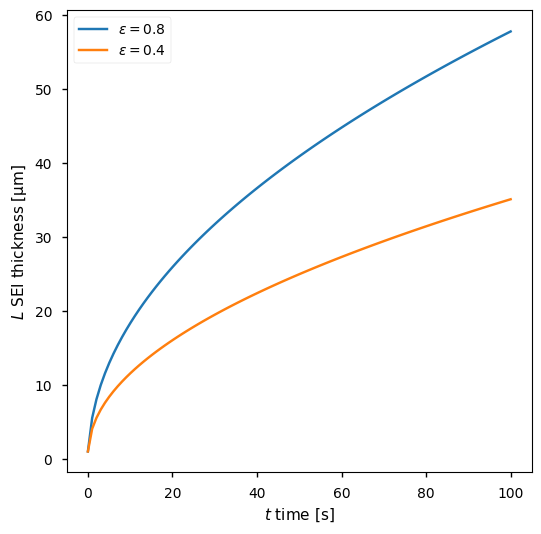

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
with plt.style.context("seaborn-v0_8-notebook"):
    ax1.plot(solution.t, L_out(solution.t) * 1e6, label=r"$\varepsilon = 0.8$")
    ax1.plot(solution_2.t, L_out_2(solution_2.t) * 1e6, label=r"$\varepsilon = 0.4$")
    ax1.legend()
    ax1.set_xlabel(r"$t$ time [s]")
    ax1.set_ylabel(r"$L$ SEI thickness $\mathrm{[\mu m]}$")

### PyBAMM SEI Model

In [46]:
model1 = pybamm.lithium_ion.DFN()
model2 = pybamm.lithium_ion.DFN(
    {"SEI": "solvent-diffusion limited", "particle mechanics": "swelling only"}
)

In [59]:
param = pybamm.ParameterValues("OKane2022")
var_pts = {
    "x_n": 20,  # negative electrode
    "x_s": 20,  # separator
    "x_p": 20,  # positive electrode
    "r_n": 26,  # negative particle
    "r_p": 26,  # positive particle
}

In [64]:
exp = pybamm.Experiment(
    # ["Hold at 4.2 V until C/100"]+
    [
        "Discharge at C/2 for 2 hours or until 2.5 V",
        "Charge at C/2 for 2.1 hours or until  4.2 V",
    ]
    * 5
)

In [65]:
sim1 = pybamm.Simulation(
    model1, parameter_values=param, experiment=exp, var_pts=var_pts
)
sol1 = sim1.solve(calc_esoh=False)
sim2 = pybamm.Simulation(
    model2, parameter_values=param, experiment=exp, var_pts=var_pts
)
sol2 = sim2.solve(calc_esoh=False)

At t = 451.851 and h = 4.33428e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.844 and h = 1.0941e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.847 and h = 1.98562e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.847 and h = 6.27504e-20, the corrector convergence failed repeatedly or with |h| = hmin.


In [72]:
t1 = sol1["Time [s]"].entries
V1 = sol1["Voltage [V]"].entries
SEI1 = sol1["Total lithium [mol]"].entries
lithium_neg1 = sol1["Total lithium in negative electrode [mol]"].entries
lithium_pos1 = sol1["Total lithium in positive electrode [mol]"].entries
t2 = sol2["Time [s]"].entries
V2 = sol2["Voltage [V]"].entries
SEI2 = sol2["Total lithium [mol]"].entries
lithium_neg2 = sol2["Total lithium in negative electrode [mol]"].entries
lithium_pos2 = sol2["Total lithium in positive electrode [mol]"].entries

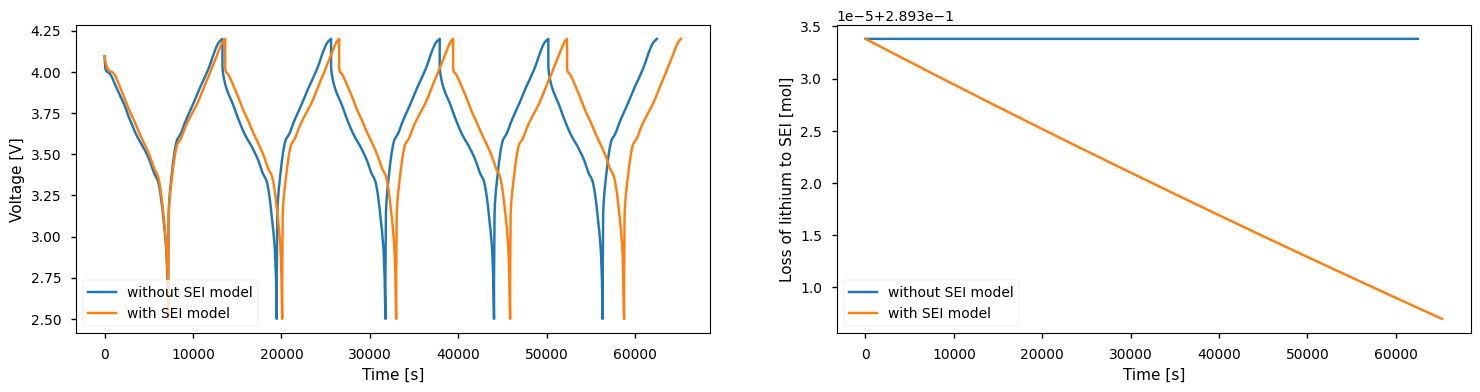

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
with plt.style.context("seaborn-v0_8-notebook"):
    ax1.plot(t1, V1, label="without SEI model")
    ax1.plot(t2, V2, label="with SEI model")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Voltage [V]")
    ax1.legend()
    ax2.plot(t1, SEI1, label="without SEI model")
    ax2.plot(t2, SEI2, label="with SEI model")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Total lithium [mol]")
    ax2.legend()
plt.show()

## [Exercise]: Is this LIB suitable for an Electric Vehicle (EV)?
Here we propose a trivial example for computing the weight of the battery pack needed for an electric vehicle.

To do so we have to:

1. Compute the required power for a certain constant velocity
2. Compute the Power needed from the battery, assuming an overall efficiency of $\eta_{o}=0.63$ (not far from reality)
3. Assuming a battery voltage of $300\; \mathrm{V}$ compute the current from the battery
4. Using the data for the Ragone plot, compute the specific power and then compute the battery mass.

### Step 1

At constant speed, the power developed by the wheels is the power needed to overcome air resistance and friction with the road.

<img src="https://github.com/paolodeangelis/Energy_storage/raw/main/img/car.png" width="600"/>

$ \dot{W}_{road} = \dot{W}_{rolling} + \dot{W}_{air-friction} $

**Rolling resistance**

$ \dot{W}_{rolling} = 9.8 M \cdot C_{rr}\cdot v $

where:
- $9.8 M$ $[\mathrm{N}]$: is the normal force
- $C_{rr}$ $[\mathrm{-}]$: is the rolling restistace coefficient (for a car tires on asphalt is $ C_{rr}=0.03 $)
- $ v$ $[\mathrm{m/s}]$: is the car velocity

**Air friction**

$ \dot{W}_{air-friction} = \dfrac{1}{2} \rho \cdot C_{D}\cdot A \cdot v^2 $

where:
- $\rho$ $[\mathrm{kg/m^2}]$: is the ari density (average value is $1.2\; \mathrm{kg/m^2}$)
- $C_{D}$ $[\mathrm{-}]$: is the air friction coefficient (for a normal car $ C_{D}=0.29 $)
- $A$ $[\mathrm{m^2}]$: is the surface of the frontal area (use a common value of $2\; \mathrm{m^2}$
- $ v$ $[\mathrm{m/s}]$: is the car velocity

In [ ]:
# data
M_car = 2000  # [kg]
speed = 130  # [km/h]
C_rr = 0.03  # [-]
rho = 1.2  # [kg/m^3]
C_D = 0.29  # [-]
A = 2  # [m^2]

# speed conversion
speed = speed / 3.6

# compute power
dotW_rolling = 9.8 * M_car * C_rr * speed
dotW_air = 0.5 * rho * C_D * A * speed**2

dotW_road = dotW_rolling + dotW_air

print(f"Power put on the road {dotW_road:1.2g} W")

Power put on the road 2.2e+04 W


### Spep 2

The overall efficiency is defined as:

$\eta_o = \dfrac{W_{road}}{W_{battery}} = 0.63$

Thus:

$\dot{W}_{battery} = \dfrac{\dot{W}_{road}}{\eta_o}$

In [ ]:
# data
eta_o = 0.63  # [-]

dotW_battery = dotW_road / eta_o

print(f"Power required from the battery {dotW_battery:1.2g} W")

Power required from the battery 3.4e+04 W


### Step 3

Compute the current (thus the C-rate) from the battery back, assuming a nominal voltage of $300\,\mathrm{V}$.

We have to remember that a single cell has a nominal voltage of $3.63\,\mathrm{V}$. This means that the battery pack is built with many cells in series (increase total voltage) and in parallel (increase the total current)

$\dot{W}_{battery} = n_{series}\cdot I_{cell}\cdot  V ⟹ I_{cell} = \dfrac{\dot{W}_{battery}}{V\cdot n_{series}}$

where

$n_{series} = \mathrm{roud}\left(\dfrac{300}{3.63}\right) = 83$

In [ ]:
# data
V = 300  # [V]
n_series = 83

I_cell = dotW_battery / V / n_series

print(f"Current battery {I_cell:1.3g} A (= {I_cell/C_RATE:1.3g} C-Rate)")

Current battery 1.38 A (= 0.276 C-Rate)


### Step 4

From the Ragone plot data, we get the specific power. And from that, we compute the battery mass

$M_{battery} = \dfrac{\dot{W}_{battery}}{\dot{w}(I_{cell})}$

In [ ]:
specific_power = f_Crate_SpecificPower(I_cell)

M_battery = dotW_battery / specific_power

print(f"The battery will weight {M_battery:1.3g} kg")

The battery will weight 95.1 kg
